In [ ]:
pip install wfdb

In [70]:
import wfdb
import numpy as np
import os
import csv
import heapq
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, Perceptron, BayesianRidge,LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier  # or KNeighborsRegressor if regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

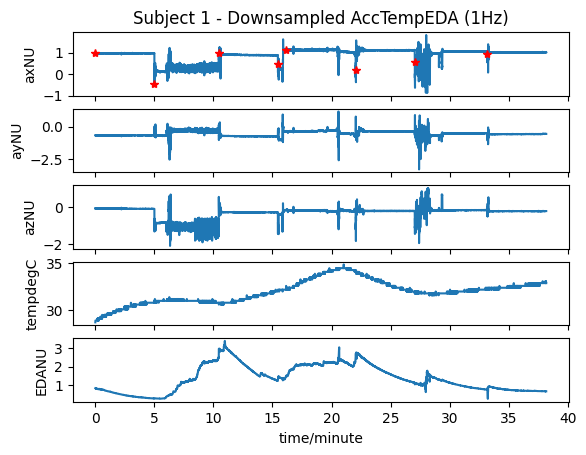

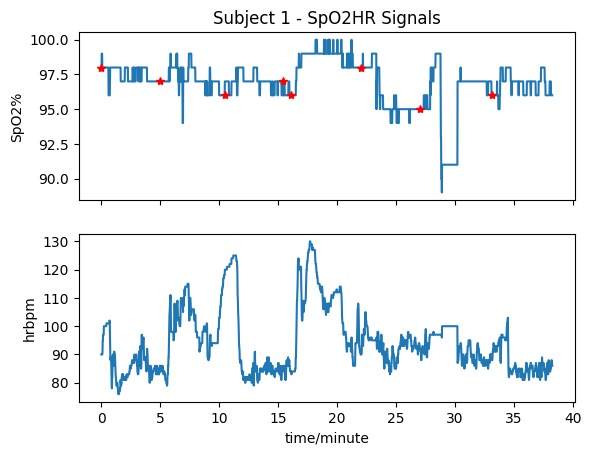

In [6]:
subject = data_list[1]  
wfdb.plot_wfdb( record=subject['acc_temp_eda'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - Downsampled AccTempEDA (1Hz)')
wfdb.plot_wfdb( record=subject['spo2_hr'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - SpO2HR Signals')

# Extracting and Combining Data by Class

## Utility functions

In [2]:
# extract the ranges of each stage from their annotation
def get_stages(annotation, size):
    stages = []
    for i, (samp, note) in enumerate(zip(annotation.sample, annotation.aux_note)):
        stages.append({"Label" : note, "start": samp, "end": 0}) # dummy end
    
    for i in range((len(stages) - 1)):
        stages[i]["end"] = stages[i+1]["start"] # each stages end is the next one's beginning
    stages[-1]["end"] = size # set the end of last stage as the length of the data

    return stages  

In [3]:
# find label of a data point at a given index based on the ranges of each stage
def find_label(stages, index):
    for stage in stages:
        if index >= stage['start'] and index < stage['end']:
            return stage["Label"]
    return "Unknown"

In [4]:
# label the AccTempEDA data
def extract_labeled_AccTempEDA(record, annotation):
    stages = get_stages(annotation, record.p_signal.shape[0]) # get the range for each stage
    data = record.p_signal # extract the data into a numpy array
    labels = [] # array to store the labels corresponding to each data point in the record
    for idx, entry in enumerate(data): # loop over all the data
        labels.append((find_label(stages, idx))) # find the label based on the points index
    labeled_data = np.column_stack((data, labels)) # append the labels column to the data 
    return labeled_data # return the labeled data

In [5]:
# downsample by averaging BUT make sure you stay within a given class
def downsample_by_averaging(data, factor):
    downsampled_data = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, :-1].astype(float) # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            avg_chunk = np.mean(chunk, axis=0)
            downsampled_data.append(np.append(avg_chunk, class_label))  # avg of each column while adding back the label
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
                    
    return np.array(downsampled_data)

In [6]:
# combine AccTempEDA and Spo2HR data while truncating them to be of the same length
# CRUCIAL but naive assumption! time stamps match after downsampling (technically incorrect)
def combine(AccTempEDA, Spo2HR):
    min_length = min(len(AccTempEDA), len(Spo2HR)) # finds the minimum length to align the points properly

    # concatenate the truncated columns from AccTempEDA with those from Spo2HR and add the labels at the end
    combined_data = np.column_stack((AccTempEDA[:min_length, :-1], Spo2HR[:min_length], AccTempEDA[:min_length, -1:]))

    return combined_data

In [7]:
def balance_classes(combined_data):
    balanced_data = []
    relaxed = False
    for data in combined_data:
        if data[-1] != "Relax": # we've passed the first relax
            relaxed = True
            balanced_data.append(data)
        elif not relaxed:
            balanced_data.append(data)
    return np.array(balanced_data)  

In [30]:
def balance_classes_leftover(combined_data):
    leftover_relax = []
    relaxed = False
    for data in combined_data:
        if data[-1] != "Relax": # we've passed the first relax
            relaxed = True
        elif relaxed:
            leftover_relax.append(data)
    return np.array(leftover_relax)

In [33]:
len(balance_classes_leftover(all_sub_info_preproc[0])) + len(balance_classes(all_sub_info_preproc[0])) - len (all_sub_info_preproc[0])

0

# Extracting Raw and Preprocessed data

In [8]:
# val is 1 incase labels are included 0 otherwise 
def preprocess(wavevec):
    final_vec = [] # stores the filtered signals
    for i in range(0,len(wavevec[0])): # goes through each point in the signal
        one_col = [wavevec[s][i].astype(float) for s in range(0,len(wavevec))] # filters column by column
        one_col = medfilt(one_col, kernel_size=9) # filtering each column
        if i == 0:
            final_vec = one_col
        else:
            final_vec = np.column_stack((final_vec, one_col))
    return final_vec

In [9]:
# get the full data for each subject
def get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [10]:
def get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [11]:
def get_subject_data_raw_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    balanced_data = balance_classes(combined_data)
    return balanced_data # return the resulting data

In [37]:
# get the full data for each subject
def get_subject_data_preprocessed_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    balanced_data = balance_classes(combined_data)
    leftover_data = balance_classes_leftover(combined_data)
    return balanced_data, leftover_data # return the resulting data

# Function to read and get raw data for all subjects and store them in csvs

In [38]:
read_directory=r"D:\University\8.Spring 2025\Machine\Project\non-eeg-dataset-for-assessment-of-neurological-status-1.0.0\non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
all_sub_info_raw = []
all_sub_info_preproc = []
all_sub_info_r_balanced = []
all_sub_info_p_balanced = []
all_sub_info_p_leftover = []
for i in range(1,21):
    ACCTEMPEDA_Path = os.path.join(read_directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(read_directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file
    subject_data_r = get_subject_data_raw(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    subject_data_p = get_subject_data_preprocessed(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    subject_data_rb = get_subject_data_raw_balanced(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    subject_data_pb, subject_data_pl = get_subject_data_preprocessed_balanced(ACCTEMPEDA_Record, SPO2HR_Record,annotations)
    all_sub_info_raw.append(subject_data_r)
    all_sub_info_preproc.append(subject_data_p)
    all_sub_info_r_balanced.append(subject_data_rb)
    all_sub_info_p_balanced.append(subject_data_pb)
    all_sub_info_p_leftover.append(subject_data_pl)

In [35]:
len(all_sub_info_p_balanced[0])

1392

In [39]:
len(all_sub_info_p_balanced[0])

1392

In [40]:
len(all_sub_info_p_leftover[0])

900

# Function to get the data in the desired window sizes

In [16]:
def windowSel(data, factor):
    # stores the windowed sample
    windowed = []
    labels = []
    i = 0
    # stores the last i in case the window exceeds the size of the sample
    while i + factor < len(data):
        class_label = data[i][-1] # get the expected class label
        if class_label != data[i + factor - 1][-1]: # if all the data doesnt belong to one class
            for x in range(i,i + factor):
                if data[x][-1] != data[x+1][-1]:
                    i = x + 1
                    break
        else:
            # adds the windowed sample
            windowed.append(data[i: i + factor, :-1])
            labels.append(class_label)
            i += factor
    return windowed, labels

In [17]:
# select windows BUT make sure you stay within a given class
def window_data(data, factor):
    windowed_data = []
    labels = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, : -1] # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            windowed_data.append(chunk)  # avg of each column while adding back the label
            labels.append(class_label)
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
    # flatten the windows

    windowed_data = [window.flatten() for window in windowed_data]
                    
    return np.array(windowed_data).astype(float), np.array(labels)

In [ ]:
windowed = []
val = 15
labels = []
for i in range(0,20):
    windowed_samps,label  = windowSel(all_sub_info_p_balanced[i],val)
    windowed_samps = [x.flatten() for x in windowed_samps]
    windowed.append(np.array(windowed_samps))
    labels.append(label)

# Compute Z score [Normalization] (importnat for methods like KNN, logistic regression, SVM and neural networks

In [20]:
# data includes the features without the labels column
def normalize_data(train_data, test_data):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)
    return X_train_scaled, X_test_scaled
    
        

# Raw vs Filtered vs Normalized vs Filtered + Normalized

In [30]:
# getting all the data we want

### Will eventually do this for all subjects

## Least Squares

In [410]:
def least_squared_all_subs(data, norm = False, window = 1):
    precision_list= []
    recall_list = []
    f1_list = []
    accuracy_list = []
    
    
    for i in range(1, 21):
        if(window == 1):
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i-1], window)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if(norm):
                X_train, X_test = normalize_data(X_train, X_test)
                
            clf = RidgeClassifier(random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(y_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        avg_accuracy = report_dict['accuracy']
    
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        f1_list.append(avg_f1_score)
        accuracy_list.append(avg_accuracy)
        
        
    overall_avg_precision = sum(precision_list) / len(precision_list)
    overall_avg_recall = sum(recall_list) / len(recall_list)
    overall_avg_f1 = sum(f1_list) / len(f1_list)
    overall_avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    print("Overall averages for 20 subjects with Least Sqaures classifier:")
    print(f"Average Precision: {overall_avg_precision:.3f}")
    print(f"Average Recall: {overall_avg_recall:.3f}")
    print(f"Average F1-Score: {overall_avg_f1:.3f}")
    print(f"Average Accuracy: {overall_avg_accuracy:.3f}")
        

### Least Squares on Raw Data (Unbalanced)

In [411]:
least_squared_all_subs(all_sub_info_raw, norm = False)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.881
Average Recall: 0.820
Average F1-Score: 0.825
Average Accuracy: 0.865


### Least Squares on Raw Data (Balanced)

In [412]:
least_squared_all_subs(all_sub_info_r_balanced, norm = False)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.943
Average Recall: 0.942
Average F1-Score: 0.940
Average Accuracy: 0.938


### Least Squares on Preprocessed (Unbalanced)

In [413]:
least_squared_all_subs(all_sub_info_preproc, norm = True)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.878
Average Recall: 0.823
Average F1-Score: 0.828
Average Accuracy: 0.866


### Least Squares on Preprocessed (Balanced)

In [414]:
least_squared_all_subs(all_sub_info_p_balanced, norm = True)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.948
Average Recall: 0.949
Average F1-Score: 0.947
Average Accuracy: 0.945


### Least Squares Windows

In [418]:
least_squared_all_subs(all_sub_info_p_balanced, True, 2)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.945
Average Recall: 0.947
Average F1-Score: 0.945
Average Accuracy: 0.942


In [420]:
least_squared_all_subs(all_sub_info_p_balanced, True, 3)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.945
Average Recall: 0.946
Average F1-Score: 0.944
Average Accuracy: 0.942


In [421]:
least_squared_all_subs(all_sub_info_p_balanced, True, 4)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.945
Average Recall: 0.946
Average F1-Score: 0.944
Average Accuracy: 0.942


In [422]:
least_squared_all_subs(all_sub_info_p_balanced, True, 5)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.938
Average Recall: 0.940
Average F1-Score: 0.937
Average Accuracy: 0.935


In [423]:
least_squared_all_subs(all_sub_info_p_balanced, True, 10)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.932
Average Recall: 0.934
Average F1-Score: 0.930
Average Accuracy: 0.927


In [424]:
least_squared_all_subs(all_sub_info_p_balanced, True, 15)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.925
Average Recall: 0.924
Average F1-Score: 0.922
Average Accuracy: 0.920


## Logistic Regression

In [18]:
def logistic_regression_all_subs(data, norm = False, window = 1):
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    
    for i in range(1, 21):
        if(window == 1):
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i-1], window)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if(norm):
                X_train, X_test = normalize_data(X_train, X_test)
                
            clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state = 42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(y_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        avg_accuracy = report_dict['accuracy']
    
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        f1_list.append(avg_f1_score)
        accuracy_list.append(avg_accuracy)
        
        
    overall_avg_precision = sum(precision_list) / len(precision_list)
    overall_avg_recall = sum(recall_list) / len(recall_list)
    overall_avg_f1 = sum(f1_list) / len(f1_list)
    overall_avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    print("Overall averages for 20 subjects with Logistic Regression classifier:")
    print(f"Average Precision: {overall_avg_precision:.3f}")
    print(f"Average Recall: {overall_avg_recall:.3f}")
    print(f"Average F1-Score: {overall_avg_f1:.3f}")
    print(f"Average Accuracy: {overall_avg_accuracy:.3f}")

### Logistic Regression on Preprocessed (Unbalanced)

In [21]:
logistic_regression_all_subs(all_sub_info_preproc, norm = True)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.942
Average Recall: 0.933
Average F1-Score: 0.936
Average Accuracy: 0.942


### Logistic Regression on Preprocessed (Balanced)

In [22]:
logistic_regression_all_subs(all_sub_info_p_balanced, norm = True)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.985
Average Recall: 0.986
Average F1-Score: 0.985
Average Accuracy: 0.984


### Logisitic Regression Windowed

In [23]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 2)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.984
Average Recall: 0.985
Average F1-Score: 0.984
Average Accuracy: 0.983


In [24]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 3)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.982
Average Recall: 0.983
Average F1-Score: 0.982
Average Accuracy: 0.981


In [25]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 4)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.980
Average Recall: 0.981
Average F1-Score: 0.980
Average Accuracy: 0.979


In [26]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 5)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.980
Average Recall: 0.981
Average F1-Score: 0.980
Average Accuracy: 0.979


In [27]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 10)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.973
Average Recall: 0.975
Average F1-Score: 0.973
Average Accuracy: 0.972


In [28]:
logistic_regression_all_subs(all_sub_info_p_balanced, True, 15)

Overall averages for 20 subjects with Logistic Regression classifier:
Average Precision: 0.971
Average Recall: 0.971
Average F1-Score: 0.970
Average Accuracy: 0.968


## SVM

In [435]:
def svm_all_subs(data, k, norm = False, window = 1):
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    
    for i in range(1, 21):
        if(window == 1):
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i-1], window)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if(norm):
                X_train, X_test = normalize_data(X_train, X_test)
                
            clf = SVC(kernel= k, decision_function_shape='ovr', random_state = 42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(y_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        avg_accuracy = report_dict['accuracy']
    
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        f1_list.append(avg_f1_score)
        accuracy_list.append(avg_accuracy)
        
        
    overall_avg_precision = sum(precision_list) / len(precision_list)
    overall_avg_recall = sum(recall_list) / len(recall_list)
    overall_avg_f1 = sum(f1_list) / len(f1_list)
    overall_avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    print("Overall averages for 20 subjects with SVM classifier:")
    print(f"Average Precision: {overall_avg_precision:.3f}")
    print(f"Average Recall: {overall_avg_recall:.3f}")
    print(f"Average F1-Score: {overall_avg_f1:.3f}")
    print(f"Average Accuracy: {overall_avg_accuracy:.3f}")

# SVM

In [17]:
def svm_all_subs(data, k, norm = False, window = 1):
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    
    for i in range(1, 21):
        if(window == 1):
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i-1], window)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if(norm):
                X_train, X_test = normalize_data(X_train, X_test)
                
            clf = SVC(kernel= k, decision_function_shape='ovr', random_state = 42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(y_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        avg_accuracy = report_dict['accuracy']
    
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        f1_list.append(avg_f1_score)
        accuracy_list.append(avg_accuracy)
        
        
    overall_avg_precision = sum(precision_list) / len(precision_list)
    overall_avg_recall = sum(recall_list) / len(recall_list)
    overall_avg_f1 = sum(f1_list) / len(f1_list)
    overall_avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    print("Overall averages for 20 subjects with SVM classifier:")
    print(f"Average Precision: {overall_avg_precision:.3f}")
    print(f"Average Recall: {overall_avg_recall:.3f}")
    print(f"Average F1-Score: {overall_avg_f1:.3f}")
    print(f"Average Accuracy: {overall_avg_accuracy:.3f}")
        

## Unnormalized also doesn't run (takes too long)

In [ ]:
# svm_all_subs(all_raw_data, 'linear', norm = False)

### Linear SVM on Preprocessed (UnBalanced)

In [18]:
svm_all_subs(all_preprocessed_data, 'linear', norm = True)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.961
Average Recall: 0.952
Average F1-Score: 0.954
Average Accuracy: 0.959


### Linear SVM on Preprocessed (Balanced)

In [19]:
svm_all_subs(all_preprocessed_data_balanced, 'linear', norm = True)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.988
Average Recall: 0.989
Average F1-Score: 0.988
Average Accuracy: 0.987


### Non-linear SVM on Preprocessed (UnBalanced)

In [20]:
svm_all_subs(all_preprocessed_data, 'rbf', norm = True)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.982
Average Recall: 0.981
Average F1-Score: 0.981
Average Accuracy: 0.984


### Non-linear SVM on Preprocessed (Balanced)

In [21]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', norm = True)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.991
Average Recall: 0.992
Average F1-Score: 0.991
Average Accuracy: 0.991


#### Observation (Linear almost same) since high dimensionality

### SVM Non-Linear Windows

In [95]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 2)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.988
Average Recall: 0.988
Average F1-Score: 0.988
Average Accuracy: 0.987


In [96]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 3)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.986
Average Recall: 0.986
Average F1-Score: 0.985
Average Accuracy: 0.984


In [97]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 4)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.983
Average Recall: 0.984
Average F1-Score: 0.983
Average Accuracy: 0.982


In [98]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 5)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.982
Average Recall: 0.982
Average F1-Score: 0.981
Average Accuracy: 0.980


In [99]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 10)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.974
Average Recall: 0.975
Average F1-Score: 0.973
Average Accuracy: 0.972


In [100]:
svm_all_subs(all_preprocessed_data_balanced, 'rbf', True, 15)

Overall averages for 20 subjects with SVM classifier:
Average Precision: 0.974
Average Recall: 0.973
Average F1-Score: 0.973
Average Accuracy: 0.972


## Gradient Boosting

In [28]:
def gradient_boosting_all_subs(data, norm = False, window = 1):
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    
    for i in range(1, 21):
        if(window == 1):
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i-1], window)
        skf = StratifiedKFold(n_splits=5)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if(norm):
                X_train, X_test = normalize_data(X_train, X_test)
                
            clf = GradientBoostingClassifier(random_state = 42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(y_test)
        
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        avg_accuracy = report_dict['accuracy']
    
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        f1_list.append(avg_f1_score)
        accuracy_list.append(avg_accuracy)
        
        
    overall_avg_precision = sum(precision_list) / len(precision_list)
    overall_avg_recall = sum(recall_list) / len(recall_list)
    overall_avg_f1 = sum(f1_list) / len(f1_list)
    overall_avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    print("Overall averages for 20 subjects with Gradient Boosting:")
    print(f"Average Precision: {overall_avg_precision:.3f}")
    print(f"Average Recall: {overall_avg_recall:.3f}")
    print(f"Average F1-Score: {overall_avg_f1:.3f}")
    print(f"Average Accuracy: {overall_avg_accuracy:.3f}")
        

In [29]:
gradient_boosting_all_subs(all_raw_data)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.865
Average Recall: 0.878
Average F1-Score: 0.867
Average Accuracy: 0.874


In [30]:
gradient_boosting_all_subs(all_raw_data_balanced)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.932
Average Recall: 0.923
Average F1-Score: 0.925
Average Accuracy: 0.922


In [31]:
gradient_boosting_all_subs(all_preprocessed_data, norm = True)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.867
Average Recall: 0.880
Average F1-Score: 0.870
Average Accuracy: 0.876


In [32]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.932
Average Recall: 0.923
Average F1-Score: 0.925
Average Accuracy: 0.923


### Note: no difference with standardization

### Gradient Boosting Windows

In [33]:
gradient_boosting_all_subs(all_raw_data_balanced, False, 2)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.929
Average Recall: 0.922
Average F1-Score: 0.923
Average Accuracy: 0.920


In [34]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, True, 2)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.927
Average Recall: 0.919
Average F1-Score: 0.920
Average Accuracy: 0.918


In [35]:
gradient_boosting_all_subs(all_raw_data_balanced, False, 3)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.936
Average Recall: 0.929
Average F1-Score: 0.930
Average Accuracy: 0.928


In [36]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, True, 3)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.935
Average Recall: 0.928
Average F1-Score: 0.929
Average Accuracy: 0.927


In [37]:
gradient_boosting_all_subs(all_raw_data_balanced, False, 5)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.929
Average Recall: 0.923
Average F1-Score: 0.923
Average Accuracy: 0.920


In [38]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, True, 5)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.929
Average Recall: 0.923
Average F1-Score: 0.923
Average Accuracy: 0.921


In [39]:
gradient_boosting_all_subs(all_raw_data_balanced, False, 10)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.918
Average Recall: 0.913
Average F1-Score: 0.913
Average Accuracy: 0.909


In [40]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, True, 10)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.918
Average Recall: 0.914
Average F1-Score: 0.913
Average Accuracy: 0.910


In [41]:
gradient_boosting_all_subs(all_raw_data_balanced, False, 15)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.916
Average Recall: 0.913
Average F1-Score: 0.912
Average Accuracy: 0.909


In [42]:
gradient_boosting_all_subs(all_preprocessed_data_balanced, True, 15)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.917
Average Recall: 0.913
Average F1-Score: 0.913
Average Accuracy: 0.909


## Least Squares leave subject out

In [57]:
def least_squared_leave_one_out(data, norm = False, window = 1):
    all_preds = []
    all_true = []
    
    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        if(window == 1):    
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)
                
        clf = RidgeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)
    
    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']
    avg_accuracy = report_dict['accuracy']
    
    print("Overall averages for 20 subjects with Least Squares Classifier:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")

In [58]:
# just checking
least_squared_leave_one_out(all_raw_data, norm = False, window = 1)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.640
Average Recall: 0.556
Average F1-Score: 0.568
Average Accuracy: 0.666


In [59]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 1)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.690
Average Recall: 0.700
Average F1-Score: 0.692
Average Accuracy: 0.690


In [60]:
# (with old aggregation)
# least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 1)

In [61]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 2)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.692
Average Recall: 0.703
Average F1-Score: 0.694
Average Accuracy: 0.692


In [62]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 3)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.693
Average Recall: 0.704
Average F1-Score: 0.696
Average Accuracy: 0.693


In [63]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 4)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.694
Average Recall: 0.705
Average F1-Score: 0.697
Average Accuracy: 0.694


In [64]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 5)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.692
Average Recall: 0.703
Average F1-Score: 0.695
Average Accuracy: 0.692


In [65]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 10)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.701
Average Recall: 0.709
Average F1-Score: 0.704
Average Accuracy: 0.699


In [66]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 15)

Overall averages for 20 subjects with Least Squares Classifier:
Average Precision: 0.716
Average Recall: 0.722
Average F1-Score: 0.718
Average Accuracy: 0.712


## Logistic regression leave subject out

In [67]:
def logistic_regression_leave_one_out(data, norm = False, window = 1):
    all_preds = []
    all_true = []
    
    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        if(window == 1):    
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)
                
        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state = 42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Collect predictions and true labels
        all_preds.extend(y_pred)
        all_true.extend(y_test)
    
    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']
    avg_accuracy = report_dict['accuracy']
    
    print("Overall averages for 20 subjects with Logistic Regression:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
    print()
        

In [68]:
# logistic_regression_all_subs(all_preprocessed_data_balanced, norm = True, window = 1)

In [69]:
logistic_regression_leave_one_out(all_preprocessed_data, norm = True, window = 1)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.613
Average Recall: 0.573
Average F1-Score: 0.583
Average Accuracy: 0.656



In [70]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 1)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.700
Average Recall: 0.700
Average F1-Score: 0.700
Average Accuracy: 0.692



In [71]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 2)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.702
Average Recall: 0.702
Average F1-Score: 0.702
Average Accuracy: 0.694



In [72]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 3)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.703
Average Recall: 0.703
Average F1-Score: 0.703
Average Accuracy: 0.695



In [73]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 4)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.701
Average Recall: 0.701
Average F1-Score: 0.701
Average Accuracy: 0.693



In [74]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 5)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.700
Average Recall: 0.701
Average F1-Score: 0.700
Average Accuracy: 0.693



In [75]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 10)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.710
Average Recall: 0.712
Average F1-Score: 0.711
Average Accuracy: 0.703



In [76]:
logistic_regression_leave_one_out(all_preprocessed_data_balanced, norm = True, window = 15)

Overall averages for 20 subjects with Logistic Regression:
Average Precision: 0.713
Average Recall: 0.716
Average F1-Score: 0.714
Average Accuracy: 0.707



## SVM Leave one out

In [77]:
def svm_leave_one_out(data, norm = False, window = 1):
    all_preds = []
    all_true = []
    
    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        if(window == 1):    
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)

        clf = SVC(kernel= 'rbf', decision_function_shape='ovr', random_state = 42)
        #clf = LinearSVC(C=0.1, max_iter=10000, random_state=42)
        # LinearSVC(random_state=42, max_iter=10000) 
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
            
        # Collect predictions and true labels
        all_preds.extend(y_pred)
        all_true.extend(y_test)
        
    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']
    avg_accuracy = report_dict['accuracy']
    
    print("Overall averages for 20 subjects with SVM:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
    print()
        

In [78]:
svm_leave_one_out(all_preprocessed_data, norm = True)

Overall averages for 20 subjects with SVM:
Average Precision: 0.560
Average Recall: 0.547
Average F1-Score: 0.553
Average Accuracy: 0.598



In [79]:
svm_leave_one_out(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with SVM:
Average Precision: 0.639
Average Recall: 0.645
Average F1-Score: 0.640
Average Accuracy: 0.632



In [80]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 2)

Overall averages for 20 subjects with SVM:
Average Precision: 0.636
Average Recall: 0.642
Average F1-Score: 0.638
Average Accuracy: 0.628



In [81]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 3)

Overall averages for 20 subjects with SVM:
Average Precision: 0.635
Average Recall: 0.640
Average F1-Score: 0.637
Average Accuracy: 0.625



In [82]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 4)

Overall averages for 20 subjects with SVM:
Average Precision: 0.636
Average Recall: 0.640
Average F1-Score: 0.637
Average Accuracy: 0.624



In [83]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 5)

Overall averages for 20 subjects with SVM:
Average Precision: 0.634
Average Recall: 0.639
Average F1-Score: 0.636
Average Accuracy: 0.623



In [84]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 10)

Overall averages for 20 subjects with SVM:
Average Precision: 0.657
Average Recall: 0.657
Average F1-Score: 0.657
Average Accuracy: 0.642



In [85]:
svm_leave_one_out(all_preprocessed_data_balanced, True, 15)

Overall averages for 20 subjects with SVM:
Average Precision: 0.674
Average Recall: 0.672
Average F1-Score: 0.673
Average Accuracy: 0.658



In [86]:
len(all_raw_data[0])*19

43548

## Gradient Boosting Leave one out

In [87]:
def gradient_boosting_leave_one_out(data, norm = False, window = 1):
    all_preds = []
    all_true = []
    
    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        if(window == 1):    
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)
                
        clf = GradientBoostingClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
            
        # Collect predictions and true labels
        all_preds.extend(y_pred)
        all_true.extend(y_test)
        
    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']
    avg_accuracy = report_dict['accuracy']
    
    print("Overall averages for 20 subjects with Gradient Boosting:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
    print()
        

In [88]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.648
Average Recall: 0.655
Average F1-Score: 0.650
Average Accuracy: 0.644



In [89]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 2)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.661
Average Recall: 0.669
Average F1-Score: 0.662
Average Accuracy: 0.657



In [90]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 3)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.666
Average Recall: 0.676
Average F1-Score: 0.668
Average Accuracy: 0.663



In [91]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 4)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.659
Average Recall: 0.670
Average F1-Score: 0.663
Average Accuracy: 0.657



In [92]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 5)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.665
Average Recall: 0.676
Average F1-Score: 0.669
Average Accuracy: 0.662



In [93]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 10)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.670
Average Recall: 0.682
Average F1-Score: 0.673
Average Accuracy: 0.668



In [94]:
gradient_boosting_leave_one_out(all_preprocessed_data_balanced, True, 15)

Overall averages for 20 subjects with Gradient Boosting:
Average Precision: 0.682
Average Recall: 0.689
Average F1-Score: 0.683
Average Accuracy: 0.676



In [ ]:
data = all_raw_data
for i in range(1, 21):
    new_data = np.vstack([data[j] for j in range(20) if j != i])


In [ ]:
len(new_data)

## Class distribution

In [84]:
from collections import Counter

In [85]:
def class_distribution_all_subs(data):
    for i in range(1, 21):
        y = data[i - 1][:, -1]  # Assuming labels are in the last column
        class_counts = Counter(y)
        print(f"Subject {i} class distribution:")
        for cls, count in sorted(class_counts.items()):
            print(f"  Class {cls}: {count} instances")
        print()

In [87]:
class_distribution_all_subs(all_raw_data_balanced)

Subject 1 class distribution:
  Class CognitiveStress: 364 instances
  Class EmotionalStress: 400 instances
  Class PhysicalStress: 328 instances
  Class Relax: 300 instances

Subject 2 class distribution:
  Class CognitiveStress: 355 instances
  Class EmotionalStress: 408 instances
  Class PhysicalStress: 327 instances
  Class Relax: 300 instances

Subject 3 class distribution:
  Class CognitiveStress: 354 instances
  Class EmotionalStress: 403 instances
  Class PhysicalStress: 324 instances
  Class Relax: 300 instances

Subject 4 class distribution:
  Class CognitiveStress: 355 instances
  Class EmotionalStress: 399 instances
  Class PhysicalStress: 327 instances
  Class Relax: 300 instances

Subject 5 class distribution:
  Class CognitiveStress: 354 instances
  Class EmotionalStress: 400 instances
  Class PhysicalStress: 326 instances
  Class Relax: 300 instances

Subject 6 class distribution:
  Class CognitiveStress: 356 instances
  Class EmotionalStress: 399 instances
  Class Phys

### KNN

In [449]:
def knn_all_subs(data, norm=False, window=1):
    precision_list_knn = []
    recall_list_knn = []
    f1_list_knn = []
    accuracy_knn=[]

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)
            
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            knn = KNeighborsClassifier()
            param_grid = {'n_neighbors': range(1, 21)}
            grid_search = GridSearchCV(knn, param_grid, cv=5)
            grid_search.fit(X_train, y_train)

            best_k = grid_search.best_params_['n_neighbors']
            final_knn = KNeighborsClassifier(n_neighbors=best_k)
            final_knn.fit(X_train, y_train)
            y_pred = final_knn.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
        accuracy_knn.append(accuracy)
        precision_list_knn.append(avg_precision)
        recall_list_knn.append(avg_recall)
        f1_list_knn.append(avg_f1_score)
    overall_accuracy_knn=sum(accuracy_knn)/len(accuracy_knn)
    overall_avg_precision_knn = sum(precision_list_knn) / len(precision_list_knn)
    overall_avg_recall_knn = sum(recall_list_knn) / len(recall_list_knn)
    overall_avg_f1_knn = sum(f1_list_knn) / len(f1_list_knn)

    print("Overall averages for 20 subjects with KNN classifier:")
    print(f"Accuracy Score: {overall_accuracy_knn:.3f}")
    print(f"Average Precision: {overall_avg_precision_knn:.3f}")
    print(f"Average Recall: {overall_avg_recall_knn:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_knn:.3f}")


### KNN on Raw Data (Unbalanced)

In [31]:
knn_all_subs(all_raw_data, norm = False)

Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.946
Average Precision: 0.939
Average Recall: 0.943
Average F1-Score: 0.941


### KNN on Raw Data (Balanced) 

In [32]:
knn_all_subs(all_raw_data_balanced, norm = False)

Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.980
Average Precision: 0.981
Average Recall: 0.981
Average F1-Score: 0.981


### KNN on Preprocessed (Unbalanced)

In [33]:
knn_all_subs(all_preprocessed_data, norm = True)

Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.987
Average Precision: 0.985
Average Recall: 0.984
Average F1-Score: 0.984


### KNN on Preprocessed (Balanced)

In [34]:
knn_all_subs(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.990
Average Precision: 0.991
Average Recall: 0.991
Average F1-Score: 0.991


### Windows 1,5,10,15

In [450]:
print("Window 1")
knn_all_subs(all_sub_info_p_balanced, norm=True,window=1)
print("Window 3")
knn_all_subs(all_sub_info_p_balanced, norm=True,window=3)
print("Window 5")
knn_all_subs(all_sub_info_p_balanced, norm=True,window=5)
print("Window 10")
knn_all_subs(all_sub_info_p_balanced, norm=True,window=10)
print("Window 15")
knn_all_subs(all_sub_info_p_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.990
Average Precision: 0.991
Average Recall: 0.991
Average F1-Score: 0.991
Window 3
Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.983
Average Precision: 0.984
Average Recall: 0.985
Average F1-Score: 0.984
Window 5
Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.976
Average Precision: 0.978
Average Recall: 0.979
Average F1-Score: 0.978
Window 10
Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.965
Average Precision: 0.968
Average Recall: 0.969
Average F1-Score: 0.967
Window 15
Overall averages for 20 subjects with KNN classifier:
Accuracy Score: 0.960
Average Precision: 0.964
Average Recall: 0.964
Average F1-Score: 0.962


### KNN leave one subject out

In [36]:
def knn_leave_one_out(data, norm=False, window=1, n_neighbors=5):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print(f"Overall averages for 20 subjects with KNN classifier (k={n_neighbors}):")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [37]:
knn_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with KNN classifier (k=5):
Average Accuracy: 0.588
Average Precision: 0.595
Average Recall: 0.603
Average F1-Score: 0.597


## Fishers Linear Discriminant

In [446]:
def fishers_lda_all_subs(data, norm=False, window=1):
    precision_list_fishers = []
    recall_list_fishers = []
    f1_list_fishers = []
    accuracy_list_fishers = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_fishers.append(avg_precision)
        recall_list_fishers.append(avg_recall)
        f1_list_fishers.append(avg_f1_score)
        accuracy_list_fishers.append(accuracy)

    overall_avg_precision_fishers = sum(precision_list_fishers) / len(precision_list_fishers)
    overall_avg_recall_fishers = sum(recall_list_fishers) / len(recall_list_fishers)
    overall_avg_f1_fishers = sum(f1_list_fishers) / len(f1_list_fishers)
    overall_avg_accuracy_fishers = sum(accuracy_list_fishers) / len(accuracy_list_fishers)

    print("Overall averages for 20 subjects with Fisher's LDA classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_fishers:.3f}")
    print(f"Average Precision: {overall_avg_precision_fishers:.3f}")
    print(f"Average Recall: {overall_avg_recall_fishers:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_fishers:.3f}")


### FLDA on Raw Data (Unbalanced)

In [39]:
fishers_lda_all_subs(all_raw_data,norm = False)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.889
Average Precision: 0.888
Average Recall: 0.868
Average F1-Score: 0.871


### FLDA on Raw Data (Balanced)

In [40]:
fishers_lda_all_subs(all_raw_data_balanced,norm = False)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.963
Average Precision: 0.965
Average Recall: 0.966
Average F1-Score: 0.965


### FLDA on Preproccesed Data (Unbalanced)

In [41]:
fishers_lda_all_subs(all_preprocessed_data,norm = True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.890
Average Precision: 0.889
Average Recall: 0.870
Average F1-Score: 0.872


### FLDA on Preproccesed Data (Balanced)

In [42]:
fishers_lda_all_subs(all_preprocessed_data_balanced,norm = True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.964
Average Precision: 0.966
Average Recall: 0.967
Average F1-Score: 0.966


### Windows 1,5,10,15

In [447]:
print("Window 1")
fishers_lda_all_subs(all_sub_info_p_balanced, norm=True,window=1)
print("Window 3")
fishers_lda_all_subs(all_sub_info_p_balanced, norm=True,window=3)
print("Window 5")
fishers_lda_all_subs(all_sub_info_p_balanced, norm=True,window=5)
print("Window 10")
fishers_lda_all_subs(all_sub_info_p_balanced, norm=True,window=10)
print("Window 15")
fishers_lda_all_subs(all_sub_info_p_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.964
Average Precision: 0.966
Average Recall: 0.967
Average F1-Score: 0.966
Window 3
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.956
Average Precision: 0.959
Average Recall: 0.960
Average F1-Score: 0.958
Window 5
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.943
Average Precision: 0.946
Average Recall: 0.948
Average F1-Score: 0.945
Window 10
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.862
Average Precision: 0.865
Average Recall: 0.870
Average F1-Score: 0.863
Window 15
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.846
Average Precision: 0.853
Average Recall: 0.856
Average F1-Score: 0.848


### Fishers Leave One Subject out

In [44]:
def fishers_lda_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Fisher's LDA classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [45]:
fishers_lda_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.699
Average Precision: 0.707
Average Recall: 0.708
Average F1-Score: 0.707


## Naive Bayes

In [444]:
def naive_bayes_all_subs(data, norm=False, window=1):
    precision_list_nb = []
    recall_list_nb = []
    f1_list_nb = []
    accuracy_list_nb = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            nb = GaussianNB()
            nb.fit(X_train, y_train)
            y_pred = nb.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_nb.append(avg_precision)
        recall_list_nb.append(avg_recall)
        f1_list_nb.append(avg_f1_score)
        accuracy_list_nb.append(accuracy)

    overall_avg_precision_nb = sum(precision_list_nb) / len(precision_list_nb)
    overall_avg_recall_nb = sum(recall_list_nb) / len(recall_list_nb)
    overall_avg_f1_nb = sum(f1_list_nb) / len(f1_list_nb)
    overall_avg_accuracy_nb = sum(accuracy_list_nb) / len(accuracy_list_nb)

    print("Overall averages for 20 subjects with Naive Bayes classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_nb:.3f}")
    print(f"Average Precision: {overall_avg_precision_nb:.3f}")
    print(f"Average Recall: {overall_avg_recall_nb:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_nb:.3f}")


### Naive Bayes on Raw Data (Unbalanced)

In [47]:
naive_bayes_all_subs(all_raw_data, norm=False)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.928
Average Precision: 0.926
Average Recall: 0.931
Average F1-Score: 0.924


### Naive Bayes on Raw Data (Balanced)

In [48]:
naive_bayes_all_subs(all_raw_data_balanced, norm=False)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.975
Average Precision: 0.977
Average Recall: 0.978
Average F1-Score: 0.977


### Naive Bayes on Preproccesed Data (Unbalanced)

In [49]:
naive_bayes_all_subs(all_preprocessed_data, norm=True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.929
Average Precision: 0.927
Average Recall: 0.931
Average F1-Score: 0.924


### Naive Bayes on Preproccesed Data (Balanced)

In [50]:
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.976
Average Precision: 0.978
Average Recall: 0.978
Average F1-Score: 0.977


### Windows 1,5,10,15

In [445]:
print("Window 1")
naive_bayes_all_subs(all_sub_info_p_balanced, norm=True,window=1)
print("Window 3")
naive_bayes_all_subs(all_sub_info_p_balanced, norm=True,window=3)
print("Window 5")
naive_bayes_all_subs(all_sub_info_p_balanced, norm=True,window=5)
print("Window 10")
naive_bayes_all_subs(all_sub_info_p_balanced, norm=True,window=10)
print("Window 15")
naive_bayes_all_subs(all_sub_info_p_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.976
Average Precision: 0.978
Average Recall: 0.978
Average F1-Score: 0.977
Window 3
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.974
Average Precision: 0.976
Average Recall: 0.976
Average F1-Score: 0.976
Window 5
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.973
Average Precision: 0.975
Average Recall: 0.975
Average F1-Score: 0.975
Window 10
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.961
Average Precision: 0.965
Average Recall: 0.961
Average F1-Score: 0.962
Window 15
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.949
Average Precision: 0.957
Average Recall: 0.948
Average F1-Score: 0.950


### Naive Bayes Leave One Subject out

In [52]:
def naive_bayes_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        nb = GaussianNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Naive Bayes classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [53]:
naive_bayes_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.689
Average Precision: 0.695
Average Recall: 0.704
Average F1-Score: 0.697


## Random Forest

In [437]:
def random_forest_all_subs(data, norm=False, window=1):
    precision_list_rf = []
    recall_list_rf = []
    f1_list_rf = []
    accuracy_list_rf = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            rf = RandomForestClassifier(random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_rf.append(avg_precision)
        recall_list_rf.append(avg_recall)
        f1_list_rf.append(avg_f1_score)
        accuracy_list_rf.append(accuracy)

    overall_avg_precision_rf = sum(precision_list_rf) / len(precision_list_rf)
    overall_avg_recall_rf = sum(recall_list_rf) / len(recall_list_rf)
    overall_avg_f1_rf = sum(f1_list_rf) / len(f1_list_rf)
    overall_avg_accuracy_rf = sum(accuracy_list_rf) / len(accuracy_list_rf)

    print("Overall averages for 20 subjects with Random Forest classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_rf:.3f}")
    print(f"Average Precision: {overall_avg_precision_rf:.3f}")
    print(f"Average Recall: {overall_avg_recall_rf:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_rf:.3f}")


### Random Forest on Raw Data (Unbalanced)

In [55]:
random_forest_all_subs(all_raw_data, norm=False)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Random Forest on Raw Data (Balanced)

In [56]:
random_forest_all_subs(all_raw_data_balanced, norm=False)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998


### Random Forest Preproccesed (Unbalanced)

In [57]:
random_forest_all_subs(all_preprocessed_data, norm=True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.997
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Random Forest Preproccesed (Balanced)

In [58]:
random_forest_all_subs(all_preprocessed_data_balanced, norm=True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998


### Random Forest Windows 1,5,10,15

In [442]:
print("Window 1")
random_forest_all_subs(all_sub_info_p_balanced, norm=True,window=1)
print("Window 3")
random_forest_all_subs(all_sub_info_p_balanced, norm=True,window=3)
print("Window 5")
random_forest_all_subs(all_sub_info_p_balanced, norm=True,window=5)
print("Window 10")
random_forest_all_subs(all_sub_info_p_balanced, norm=True,window=10)
print("Window 15")
random_forest_all_subs(all_sub_info_p_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998
Window 3
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.994
Average Precision: 0.994
Average Recall: 0.994
Average F1-Score: 0.994
Window 5
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.992
Average Precision: 0.992
Average Recall: 0.992
Average F1-Score: 0.992
Window 10
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.979
Average Precision: 0.980
Average Recall: 0.981
Average F1-Score: 0.980
Window 15
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.974
Average Precision: 0.976
Average Recall: 0.977
Average F1-Score: 0.976


###  Random Forest Leave subject out

In [60]:
def random_forest_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Random Forest classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [61]:
random_forest_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.627
Average Precision: 0.640
Average Recall: 0.635
Average F1-Score: 0.628


## Preceptron

In [160]:
def preceptron(num_data,factor,data_train,data_test,labels_train):
    prc = Perceptron(max_iter=num_data, eta0=factor, random_state=10)
    prc.fit(data_train,labels_train)
    return prc.predict(data_test)

In [297]:
def preceptron_all_subs(info,y, norm = False, window = False):
    precision_list_preceptron = []
    recall_list_preceptron = []
    f1_list_preceptron = []
    accuracy = []
    
    for i in range(1, 21):
        if window:
            data = info[i - 1].astype(float)
            labels = np.array(y[i - 1])
        else:
            data, labels = info[i - 1][:, :-1].astype(float), info[i - 1][:, -1]
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(data, labels):
            data_train, data_test = data[train_index], data[test_index]
            labels_train, labels_test = labels[train_index], labels[test_index]

            if(norm):
                data_train, data_test = normalize_data(data_train, data_test)
                
            y_pred = preceptron(len(data[i]) + 100,0.01,data_train,data_test,labels_train)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(labels_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
    
        precision_list_preceptron.append(avg_precision)
        recall_list_preceptron.append(avg_recall)
        f1_list_preceptron.append(avg_f1_score)
        accuracy.append(accuracy_score(all_true,all_preds))
        
    overall_avg_precision_preceptron = sum(precision_list_preceptron) / len(precision_list_preceptron)
    overall_avg_recall_preceptron = sum(recall_list_preceptron) / len(recall_list_preceptron)
    overall_avg_f1_preceptron = sum(f1_list_preceptron) / len(f1_list_preceptron)
    overall_avg_acc = sum(accuracy)/len(accuracy)
    
    print("Overall averages for 20 subjects with Preceptron classifier:")
    print(f"Average Accuracy: {overall_avg_acc:.3f}")
    print(f"Average Precision: {overall_avg_precision_preceptron:.3f}")
    print(f"Average Recall: {overall_avg_recall_preceptron:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_preceptron:.3f}")

### Raw data

In [319]:
preceptron_all_subs(all_sub_info_raw,[], norm = False, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.595
Average Precision: 0.597
Average Recall: 0.546
Average F1-Score: 0.541


#### Standardized + Raw data

In [321]:
preceptron_all_subs(all_sub_info_raw,[], norm = True, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.902
Average Precision: 0.903
Average Recall: 0.886
Average F1-Score: 0.890


### Preprocessed

In [322]:
preceptron_all_subs(all_sub_info_preproc, [], norm = False, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.604
Average Precision: 0.618
Average Recall: 0.559
Average F1-Score: 0.548


#### Standardized + Preprocessed data

In [323]:
preceptron_all_subs(all_sub_info_preproc, [], norm = True, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.907
Average Precision: 0.909
Average Recall: 0.893
Average F1-Score: 0.897


### Windows

#### window of 2

In [324]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.908
Average Precision: 0.900
Average Recall: 0.900
Average F1-Score: 0.899


#### window of 3

In [331]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.898
Average Precision: 0.891
Average Recall: 0.887
Average F1-Score: 0.887


#### window of 5

In [333]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.890
Average Precision: 0.877
Average Recall: 0.875
Average F1-Score: 0.874


#### window of 10

In [335]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.887
Average Precision: 0.868
Average Recall: 0.868
Average F1-Score: 0.865


#### window of 15

In [337]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.880
Average Precision: 0.853
Average Recall: 0.858
Average F1-Score: 0.851


## Balanced

### Raw

In [338]:
preceptron_all_subs(all_sub_info_r_balanced, [], norm = False, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.688
Average Precision: 0.725
Average Recall: 0.692
Average F1-Score: 0.673


### Raw + normalized

In [339]:
preceptron_all_subs(all_sub_info_r_balanced, [], norm = True, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.965
Average Precision: 0.966
Average Recall: 0.968
Average F1-Score: 0.966


### Filtered

In [340]:
preceptron_all_subs(all_sub_info_p_balanced, [], norm = False, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.663
Average Precision: 0.680
Average Recall: 0.667
Average F1-Score: 0.649


### Filtered + Normalized

In [341]:
preceptron_all_subs(all_sub_info_p_balanced, [], norm = True, window = False)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.966
Average Precision: 0.967
Average Recall: 0.969
Average F1-Score: 0.968


### Windows

#### window of 2

In [379]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.965
Average Precision: 0.967
Average Recall: 0.967
Average F1-Score: 0.967


#### window of 3

In [381]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.959
Average Precision: 0.961
Average Recall: 0.962
Average F1-Score: 0.960


#### window of 5

In [383]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.957
Average Precision: 0.958
Average Recall: 0.960
Average F1-Score: 0.958


#### window of 10

In [385]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.947
Average Precision: 0.949
Average Recall: 0.951
Average F1-Score: 0.948


#### window of 15

In [387]:
preceptron_all_subs(windowed,labels, norm = True, window = True)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.935
Average Precision: 0.937
Average Recall: 0.939
Average F1-Score: 0.936


In [453]:
def preceptron_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        y_pred = preceptron(2000,0.01,X_train,X_test,y_train)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Preceptron classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")

In [454]:
preceptron_leave_one_out(all_sub_info_p_balanced, norm=True, window=1)

Overall averages for 20 subjects with Preceptron classifier:
Average Accuracy: 0.598
Average Precision: 0.596
Average Recall: 0.612
Average F1-Score: 0.600


## Decision Trees

In [188]:
def decision_tree(data_train,labels_train,data_test):
    DT = DecisionTreeClassifier(criterion='entropy', class_weight='balanced',max_depth=None, random_state=10)
    DT.fit(data_train,labels_train)
    return DT.predict(data_test)

In [320]:
def decision_tree_all_subs(info,y, norm = False,window = False):
    precision_list_tree = []
    recall_list_tree = []
    f1_list_tree = []
    accuracy = []
    
    for i in range(1, 21):
        if window:
            data = info[i - 1].astype(float)
            labels = np.array(y[i - 1])
        else:
            data, labels = info[i - 1][:, :-1].astype(float), info[i - 1][:, -1]
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(data, labels):
            data_train, data_test = data[train_index], data[test_index]
            labels_train, labels_test = labels[train_index], labels[test_index]

            if(norm):
                data_train, data_test = normalize_data(data_train, data_test)
                
            y_pred = decision_tree(data_train,labels_train,data_test)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(labels_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
    
        precision_list_tree.append(avg_precision)
        recall_list_tree.append(avg_recall)
        f1_list_tree.append(avg_f1_score)
        accuracy.append(accuracy_score(all_true,all_preds))
        
    overall_avg_precision_tree = sum(precision_list_tree) / len(precision_list_tree)
    overall_avg_recall_tree = sum(recall_list_tree) / len(recall_list_tree)
    overall_avg_f1_tree = sum(f1_list_tree) / len(f1_list_tree)
    overall_avg_acc = sum(accuracy)/len(accuracy)
    
    print("Overall averages for 20 subjects with Decision tree classifier:")
    print(f"Average Accuracy: {overall_avg_acc:.3f}")
    print(f"Average Precision: {overall_avg_precision_tree:.3f}")
    print(f"Average Recall: {overall_avg_recall_tree:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_tree:.3f}")

### Raw Data

In [342]:
decision_tree_all_subs(all_sub_info_raw,[], norm = False,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.992
Average Precision: 0.991
Average Recall: 0.989
Average F1-Score: 0.990


#### Standardized + Raw data

In [343]:
decision_tree_all_subs(all_sub_info_raw,[], norm = True,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.991
Average Precision: 0.991
Average Recall: 0.989
Average F1-Score: 0.990


### Preprocessed

In [344]:
decision_tree_all_subs(all_sub_info_preproc, [], norm = False,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.993
Average Precision: 0.992
Average Recall: 0.991
Average F1-Score: 0.992


#### Standardized + Preprocessed data

In [345]:
decision_tree_all_subs(all_sub_info_preproc, [], norm = True,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.993
Average Precision: 0.992
Average Recall: 0.991
Average F1-Score: 0.992


### Windows

#### window 2

In [348]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.986
Average Precision: 0.984
Average Recall: 0.982
Average F1-Score: 0.983


#### window 3

In [350]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.980
Average Precision: 0.977
Average Recall: 0.974
Average F1-Score: 0.976


#### window 5

In [352]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.969
Average Precision: 0.966
Average Recall: 0.959
Average F1-Score: 0.962


#### window 10

In [354]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.949
Average Precision: 0.941
Average Recall: 0.933
Average F1-Score: 0.937


#### window 15

In [346]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.939
Average Precision: 0.932
Average Recall: 0.919
Average F1-Score: 0.924


## Balanced

### Raw

In [355]:
decision_tree_all_subs(all_sub_info_r_balanced,[], norm = False,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Raw + Normalized

In [356]:
decision_tree_all_subs(all_sub_info_r_balanced,[], norm = True,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Filtered

In [357]:
decision_tree_all_subs(all_sub_info_p_balanced,[], norm = False,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Filtered + Normalized

In [358]:
decision_tree_all_subs(all_sub_info_p_balanced,[], norm = True,window = False)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Windows

#### window 2

In [390]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.991
Average Precision: 0.991
Average Recall: 0.991
Average F1-Score: 0.991


#### window 3

In [392]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.985
Average Precision: 0.986
Average Recall: 0.986
Average F1-Score: 0.986


#### window 5

In [394]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.979
Average Precision: 0.980
Average Recall: 0.980
Average F1-Score: 0.980


#### window 10

In [396]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.963
Average Precision: 0.965
Average Recall: 0.967
Average F1-Score: 0.965


#### window 15

In [399]:
decision_tree_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Decision tree classifier:
Average Accuracy: 0.953
Average Precision: 0.956
Average Recall: 0.956
Average F1-Score: 0.955


In [457]:
def Decision_tree_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        y_pred = decision_tree(X_train,y_train,X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Decision Tree classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")

In [458]:
Decision_tree_leave_one_out(all_sub_info_p_balanced, norm=True, window=1)

Overall averages for 20 subjects with Decision Tree classifier:
Average Accuracy: 0.542
Average Precision: 0.556
Average Recall: 0.549
Average F1-Score: 0.550


## Artifical Neural Network

In [66]:
def ANN(data_train,data_test,labels_train,num):
    ann = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=num)
    ann.fit(data_train, labels_train)
    return ann.predict(data_test)

In [359]:
def ANN_all_subs(info,y, norm = False,window = False):
    precision_list_ann = []
    recall_list_ann = []
    f1_list_ann = []
    accuracy = []
    
    for i in range(1, 21):
        if window:
            data = info[i - 1].astype(float)
            labels = np.array(y[i - 1])
        else:
            data, labels = info[i - 1][:, :-1].astype(float), info[i - 1][:, -1]
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Prepare lists to store metrics for each fold
        all_preds = []
        all_true = []
        for train_index, test_index in skf.split(data, labels):
            data_train, data_test = data[train_index], data[test_index]
            labels_train, labels_test = labels[train_index], labels[test_index]

            if(norm):
                data_train, data_test = normalize_data(data_train, data_test)
                
            y_pred = ANN(data_train,data_test,labels_train,2000)
            
            # Collect predictions and true labels
            all_preds.extend(y_pred)
            all_true.extend(labels_test)
    
        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
    
        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']
    
        precision_list_ann.append(avg_precision)
        recall_list_ann.append(avg_recall)
        f1_list_ann.append(avg_f1_score)
        accuracy.append(accuracy_score(all_true,all_preds))
        
    overall_avg_precision_ann = sum(precision_list_ann) / len(precision_list_ann)
    overall_avg_recall_ann = sum(recall_list_ann) / len(recall_list_ann)
    overall_avg_f1_ann = sum(f1_list_ann) / len(f1_list_ann)
    overall_avg_acc = sum(accuracy)/len(accuracy)

    
    print("Overall averages for 20 subjects with Artifical Neural Network classifier:")
    print(f"Average Accuracy: {overall_avg_acc:.3f}")
    print(f"Average Precision: {overall_avg_precision_ann:.3f}")
    print(f"Average Recall: {overall_avg_recall_ann:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_ann:.3f}")

### Raw Data

In [360]:
ANN_all_subs(all_sub_info_raw,[], norm = False,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.892
Average Precision: 0.894
Average Recall: 0.870
Average F1-Score: 0.876


#### Standardized + Raw data

In [361]:
ANN_all_subs(all_sub_info_raw,[], norm = True,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.994
Average Precision: 0.993
Average Recall: 0.993
Average F1-Score: 0.993


### Preprocessed

In [362]:
ANN_all_subs(all_sub_info_preproc,[], norm = False,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.896
Average Precision: 0.896
Average Recall: 0.874
Average F1-Score: 0.879


#### Standardized + Preprocessed data

In [363]:
ANN_all_subs(all_sub_info_preproc,[], norm = True,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.996
Average Precision: 0.995
Average Recall: 0.995
Average F1-Score: 0.995


### Windows

#### window 2

In [365]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.989
Average Precision: 0.987
Average Recall: 0.988
Average F1-Score: 0.988


#### window 3

In [367]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.984
Average Precision: 0.982
Average Recall: 0.981
Average F1-Score: 0.981


#### window 5

In [369]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.977
Average Precision: 0.974
Average Recall: 0.971
Average F1-Score: 0.973


#### window 10

In [371]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.962
Average Precision: 0.957
Average Recall: 0.954
Average F1-Score: 0.955


#### window 15

In [373]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.959
Average Precision: 0.954
Average Recall: 0.948
Average F1-Score: 0.950


## Balanced

### Raw

In [374]:
ANN_all_subs(all_sub_info_r_balanced,[], norm = False,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.970
Average Precision: 0.971
Average Recall: 0.972
Average F1-Score: 0.971


### Raw + Normalized

In [375]:
ANN_all_subs(all_sub_info_r_balanced,[], norm = True,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.996
Average Precision: 0.997
Average Recall: 0.997
Average F1-Score: 0.997


### Filtered

In [376]:
ANN_all_subs(all_sub_info_p_balanced,[], norm = False,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.971
Average Precision: 0.972
Average Recall: 0.973
Average F1-Score: 0.973


### Filtered + Normalized

In [377]:
ANN_all_subs(all_sub_info_p_balanced,[], norm = True,window = False)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.997
Average Precision: 0.997
Average Recall: 0.997
Average F1-Score: 0.997


### Windows

#### window 2

In [401]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.993
Average Precision: 0.994
Average Recall: 0.993
Average F1-Score: 0.993


#### window 3

In [403]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.991
Average Precision: 0.991
Average Recall: 0.992
Average F1-Score: 0.992


#### window 5

In [405]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.986
Average Precision: 0.986
Average Recall: 0.987
Average F1-Score: 0.986


#### window 10

In [407]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.973
Average Precision: 0.975
Average Recall: 0.976
Average F1-Score: 0.975


#### window 15

In [409]:
ANN_all_subs(windowed,labels, norm = True,window = True)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.966
Average Precision: 0.968
Average Recall: 0.968
Average F1-Score: 0.967


In [460]:
def ANN_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        y_pred = ANN(X_train,X_test,y_train,2000)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Artifical Neural Network classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")

In [461]:
ANN_leave_one_out(all_sub_info_p_balanced, norm=True, window=1)

Overall averages for 20 subjects with Artifical Neural Network classifier:
Average Accuracy: 0.607
Average Precision: 0.631
Average Recall: 0.614
Average F1-Score: 0.616


## Testing Leftover Relax for 3 classifiers (linear: least squares, non-linear: knn, ensemble: ANN)

In [84]:
classes = sorted(["Relax", "PhysicalStress", "EmotionalStres", "CognitiveStress"])

In [80]:
def ANN_leftover(balanced_data, leftover_data):
    precision_list_rf = []
    recall_list_rf = []
    f1_list_rf = []
    accuracy_list_rf = []
    all_preds = []
    all_true = []

    for i in range(1, 21):
        X_train, y_train = balanced_data[i - 1][:, :-1].astype(float), balanced_data[i - 1][:, -1]
        X_test, y_test = leftover_data[i - 1][:, :-1].astype(float), leftover_data[i - 1][:, -1]

        X_train, X_test = normalize_data(X_train, X_test)

        y_pred = ANN(X_train,X_test,y_train,2000)
        all_preds.extend(y_pred)
        all_true.extend(y_test)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        weighted_avg = report_dict['weighted avg']
        accuracy = report_dict['accuracy']

        avg_precision = weighted_avg['precision']
        avg_recall = weighted_avg['recall']
        avg_f1_score = weighted_avg['f1-score']

        precision_list_rf.append(avg_precision)
        recall_list_rf.append(avg_recall)
        f1_list_rf.append(avg_f1_score)
        accuracy_list_rf.append(accuracy)

    overall_avg_precision_rf = sum(precision_list_rf) / len(precision_list_rf)
    overall_avg_recall_rf = sum(recall_list_rf) / len(recall_list_rf)
    overall_avg_f1_rf = sum(f1_list_rf) / len(f1_list_rf)
    overall_avg_accuracy_rf = sum(accuracy_list_rf) / len(accuracy_list_rf)

    print("Overall averages for 20 subjects with ANN classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_rf:.3f}")
    print(f"Average Precision: {overall_avg_precision_rf:.3f}")
    print(f"Average Recall: {overall_avg_recall_rf:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_rf:.3f}")

    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

Overall averages for 20 subjects with ANN classifier:
Average Accuracy: 0.065
Average Precision: 0.600
Average Recall: 0.065
Average F1-Score: 0.105


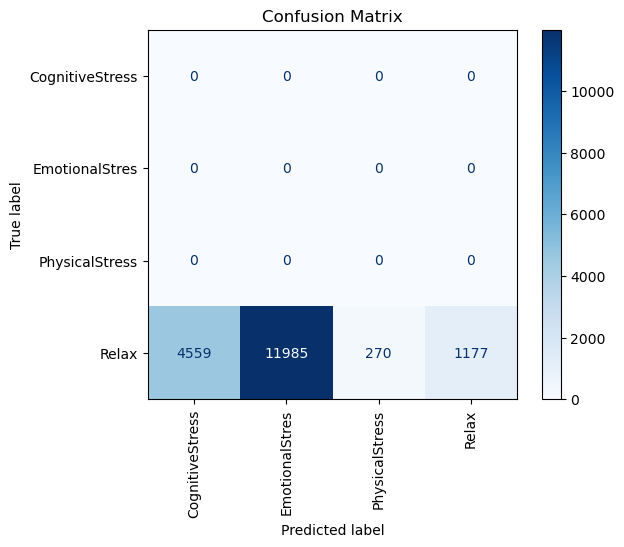

In [86]:
ANN_leftover(all_sub_info_p_balanced, all_sub_info_p_leftover)

In [87]:
def KNN_leftover(balanced_data, leftover_data):
    precision_list_rf = []
    recall_list_rf = []
    f1_list_rf = []
    accuracy_list_rf = []
    all_preds = []
    all_true = []

    for i in range(1, 21):
        X_train, y_train = balanced_data[i - 1][:, :-1].astype(float), balanced_data[i - 1][:, -1]
        X_test, y_test = leftover_data[i - 1][:, :-1].astype(float), leftover_data[i - 1][:, -1]

        X_train, X_test = normalize_data(X_train, X_test)

        knn = KNeighborsClassifier()
        param_grid = {'n_neighbors': range(1, 21)}
        grid_search = GridSearchCV(knn, param_grid, cv=5)
        grid_search.fit(X_train, y_train)

        best_k = grid_search.best_params_['n_neighbors']
        final_knn = KNeighborsClassifier(n_neighbors=best_k)
        final_knn.fit(X_train, y_train)
        y_pred = final_knn.predict(X_test)
        all_preds.extend(y_pred)
        all_true.extend(y_test)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        weighted_avg = report_dict['weighted avg']
        accuracy = report_dict['accuracy']

        avg_precision = weighted_avg['precision']
        avg_recall = weighted_avg['recall']
        avg_f1_score = weighted_avg['f1-score']

        precision_list_rf.append(avg_precision)
        recall_list_rf.append(avg_recall)
        f1_list_rf.append(avg_f1_score)
        accuracy_list_rf.append(accuracy)

    overall_avg_precision_rf = sum(precision_list_rf) / len(precision_list_rf)
    overall_avg_recall_rf = sum(recall_list_rf) / len(recall_list_rf)
    overall_avg_f1_rf = sum(f1_list_rf) / len(f1_list_rf)
    overall_avg_accuracy_rf = sum(accuracy_list_rf) / len(accuracy_list_rf)

    print("Overall averages for 20 subjects with KNN classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_rf:.3f}")
    print(f"Average Precision: {overall_avg_precision_rf:.3f}")
    print(f"Average Recall: {overall_avg_recall_rf:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_rf:.3f}")
    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

Overall averages for 20 subjects with KNN classifier:
Average Accuracy: 0.059
Average Precision: 0.500
Average Recall: 0.059
Average F1-Score: 0.089


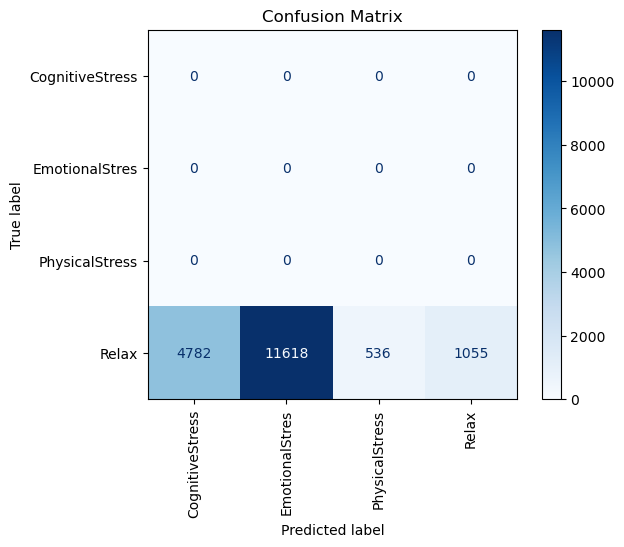

In [88]:
KNN_leftover(all_sub_info_p_balanced, all_sub_info_p_leftover)

In [78]:
def least_squares_leftover(balanced_data, leftover_data):
    precision_list_rf = []
    recall_list_rf = []
    f1_list_rf = []
    accuracy_list_rf = []
    all_preds = []
    all_true = []

    for i in range(1, 21):
        X_train, y_train = balanced_data[i - 1][:, :-1].astype(float), balanced_data[i - 1][:, -1]
        X_test, y_test = leftover_data[i - 1][:, :-1].astype(float), leftover_data[i - 1][:, -1]

        X_train, X_test = normalize_data(X_train, X_test)

        clf = RidgeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        all_preds.extend(y_pred)
        all_true.extend(y_test)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        weighted_avg = report_dict['weighted avg']
        accuracy = report_dict['accuracy']

        avg_precision = weighted_avg['precision']
        avg_recall = weighted_avg['recall']
        avg_f1_score = weighted_avg['f1-score']

        precision_list_rf.append(avg_precision)
        recall_list_rf.append(avg_recall)
        f1_list_rf.append(avg_f1_score)
        accuracy_list_rf.append(accuracy)

    overall_avg_precision_rf = sum(precision_list_rf) / len(precision_list_rf)
    overall_avg_recall_rf = sum(recall_list_rf) / len(recall_list_rf)
    overall_avg_f1_rf = sum(f1_list_rf) / len(f1_list_rf)
    overall_avg_accuracy_rf = sum(accuracy_list_rf) / len(accuracy_list_rf)

    print("Overall averages for 20 subjects with Least Squares classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_rf:.3f}")
    print(f"Average Precision: {overall_avg_precision_rf:.3f}")
    print(f"Average Recall: {overall_avg_recall_rf:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_rf:.3f}")
    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.085
Average Precision: 0.550
Average Recall: 0.085
Average F1-Score: 0.134


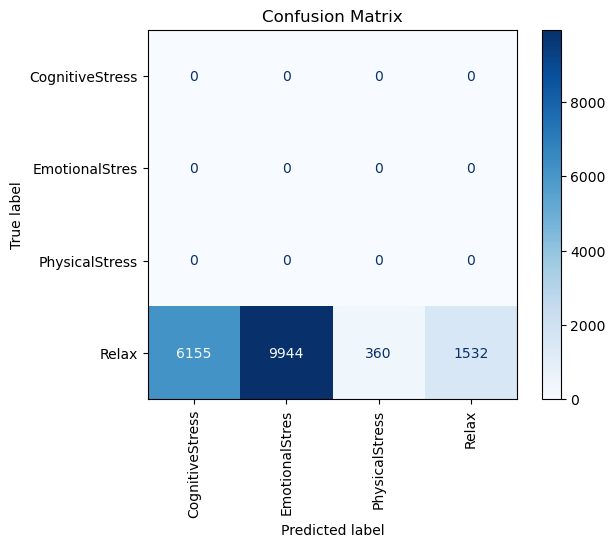

In [85]:
least_squares_leftover(all_sub_info_p_balanced, all_sub_info_p_leftover)